This [Jupyter Notebook](http://jupyter.org/) is a research notebook that I use to analyze incident pressure data from a blast.  Table 1 below is the list of the data acquisition (DAC) channels, the distance from the $200\:g$ charge and what is being measured.  If you are interested in obtaining the python code please go to my [Github](https://github.com/lightsquared/Blog/blob/master/Incident%20Pressure%20Analysis/Incident%20Overpressure%20Analysis.ipynb).

*Table 1*: DAC Channels Used in a Test Explosion Along with the Distance from the Charge to the Sensor.

| Channel | Distance (m) | Measurement |
|---------|----------|-------------|
| **1**     | **2**      | **Incident**  |
| 2       | 2        | Incident    |
| 3       | 4        | Incident    |
| 4       | 4        | Incident    |
| 5       | 6        | Incident    |
| 6       | 6        | Incident    |
| 7       | 2        | Reflected   |
| 8       | 4        | Reflected   |
| 9       | 6        | Reflected   |
| 10      | NA       | Trigger     |

All of this can be done in [Microsoft Excel](https://products.office.com/en-US/excel?legRedir=true&CorrelationId=6189e20d-3333-4b7e-a36d-23a4c0232961) however, I have found that it is difficult to follow and more importantly reproduce what some other researcher does in Microsoft Excel.  I use the Jupyter Notebook because it is reproducible python code, I can write full text in [MarkDown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to describe my thoughts, and I can write equations in [Latex](https://www.latex-project.org/) to support my analysis.

Most Jupyter Notebooks start my loading libraries needed for the analysis.  That is what I have done below, along with setting up constants in the analysis, and loading the data to be analyzed.

In [53]:
#Read CSV file
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelmax

%matplotlib inline
import pandas as pd
from io import StringIO

# Set plot height x width to golden ratio.
h = 8
w = h*1.61803398875

# Set constants for analysis.  This will change from shot to shot.
cH = 'CH 1 [psi]'               # Set cH to the channel of interest.
dist_m    = 2                   #meters
weight_g  = 200*1.3             #convert to TNT
sensor = "Incident"             #pressure sensor type for analysis.

dist_ft   = dist_m*3.28084      # convert distance in meters to distance in feet.
weight_lb = weight_g*0.00220462 # convert weigth in grams to weight in pounds.

# Set font to serif style to match Times New Roman.
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 22}
plt.rc('font', **font)

# Load the data for analysis into a Pandas dataframe.
shot = "./data.CSV"
shot_data = pd.read_csv(shot, index_col="Time [s]") # read the CSV data into a dataframe and set the Time [s] as the index.
shot_data.head() # Show the first 5 rows of data loaded into the dataframe "shot_data".

,CH 1 [psi],CH 2 [psi],CH 3 [psi],CH 4 [psi],CH 5 [psi],CH 6 [psi],CH 7 [psi],CH 8 [psi],CH 9 [psi],CH 10 [v]
Time [s],,,,,,,,,,
-0.000335,-0.022220,-0.030488,0.000000,-0.003067,-0.005841,0.004323,0.000000,-0.024862,0.018586,4.99542
-0.000334,-0.017459,0.005807,-0.014274,-0.013803,-0.020442,0.001441,-0.104681,0.068369,0.012390,4.99542
-0.000334,-0.019046,-0.001452,-0.012847,0.009202,-0.008761,0.017290,0.000000,0.006215,0.018586,4.99542
-0.000333,-0.030156,-0.033392,-0.019983,-0.013803,-0.020442,0.000000,0.043104,0.043508,0.018586,4.99542
-0.000333,-0.026981,0.007259,0.005710,0.019938,-0.002920,0.000000,-0.030788,0.155385,0.037171,4.99542


In [54]:
# from numpy import sqrt # import the square root function.
sd = dist_ft/np.cbrt(weight_lb) # calcuate scaled distance.
f_sd = format(sd, '0.3f') # format output.
weight_lb, dist_m, dist_ft, f_sd

(0.5732012, 2, 6.56168, '7.899')

The charge was 200 g (0.57 lb) and the transducer was 2 m (6.56 ft) for a scaled distance of: 7.90 $\frac{ft}{^3\sqrt{lb}}$.

Change the dataframe index time from seconds to milliseconds.  First create a new column called "Time [msec]" that is equal to the current index muliplied by 1000.  Then set the new column "Time [msec]" as the dataframe's new index.

In [55]:
shot_data['Time [msec]'] = shot_data.index*1000 #create a new column in the dataframe called Time [msec].
shot_data.set_index('Time [msec]', inplace=True) #set the new column as the dataframe index.
shot_data.head() #view the first 5 rows of the updated dataframe.

,CH 1 [psi],CH 2 [psi],CH 3 [psi],CH 4 [psi],CH 5 [psi],CH 6 [psi],CH 7 [psi],CH 8 [psi],CH 9 [psi],CH 10 [v]
Time [msec],,,,,,,,,,
-0.3350,-0.022220,-0.030488,0.000000,-0.003067,-0.005841,0.004323,0.000000,-0.024862,0.018586,4.99542
-0.3345,-0.017459,0.005807,-0.014274,-0.013803,-0.020442,0.001441,-0.104681,0.068369,0.012390,4.99542
-0.3340,-0.019046,-0.001452,-0.012847,0.009202,-0.008761,0.017290,0.000000,0.006215,0.018586,4.99542
-0.3335,-0.030156,-0.033392,-0.019983,-0.013803,-0.020442,0.000000,0.043104,0.043508,0.018586,4.99542
-0.3330,-0.026981,0.007259,0.005710,0.019938,-0.002920,0.000000,-0.030788,0.155385,0.037171,4.99542


Just for a check, if we take 1,000 times the reciprocal of the difference between index values we should get the sample rate.

In [56]:
shot_data["Diff"] = shot_data.index # creates a new column called Diff in the dataframe and sets it equal to the index.
shot_data["Diff"] = (shot_data['Diff'] - shot_data['Diff'].shift())  #subtract the current from the next row.
difference = shot_data['Diff'].iloc[1] # find difference in the second row of column Diff.
f_sample_rate = format(round(1000*(1/difference)), '0,.0f')
f_sample_rate

'2,000,000'

The sample rate based on the time index in the data is 2,000,000 S/s.

Now I would like to plot the data channel of interest.  This was set in the first code cell as "CH 1 [psi]".

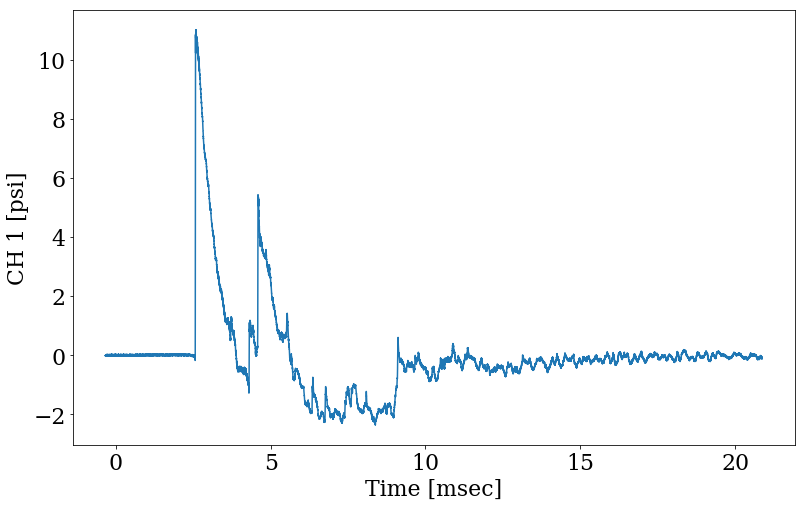

In [57]:
start = -50 # Set plot start time.
end   = 50 # Set plot end time.

shot_data[cH][start:end].plot(figsize=(w,h));
plt.ylabel(cH);

## DC Bias Removal
All signals have DC bias.  We can check and remove any DC bias by taking the mean of the data up to the trigger value.

In [58]:
# Take the mean of the data channel data up to time = 0 and extract the 1 first term.
cH_DC = shot_data[[cH]][:0].mean()[0]
f_cH_DC = format(cH_DC, '0.6f')
f_cH_DC

'0.001578'

The DC bias for this channel was 0.001578 psi.  We can now remove the DC bias from the channel and replot.

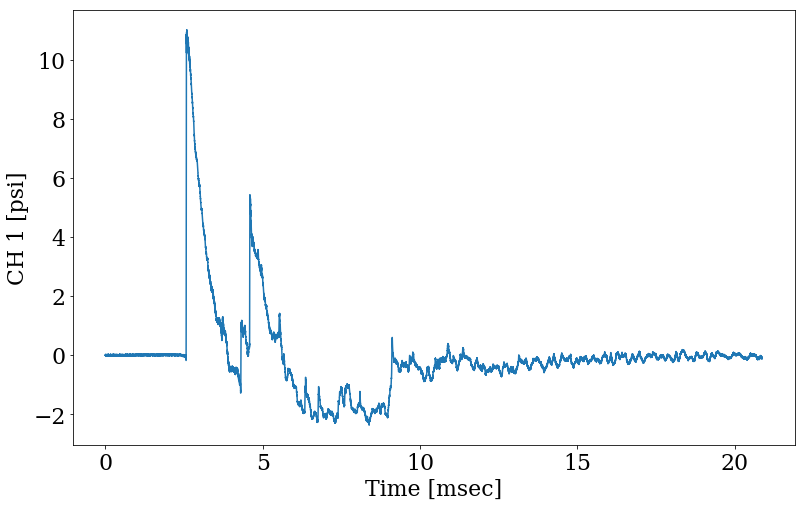

In [59]:
shot_data_dc = shot_data[cH] - cH_DC;
shot_data_dc[0:25].plot(figsize=(w,h));
plt.ylabel(cH);

## Peak Pressure and Positive Phase Duration

The local maximum value of the pressure for the channel is found along with the time at maxiumum pressure.

In [60]:
#Find measuered peak overpressure and the time it occurs
peak_p = max(shot_data_dc[0:25]) #peak pressure.
peak_t = shot_data_dc[0:25].idxmax() #time at peak pressure.
f_peak_t = format(peak_t, '0.3f')
f_peak_p = format(peak_p, '0.3f')
f_peak_p, f_peak_t

('11.012', '2.587')

The maximum pressure occurs at the point (2.587 ms,11.012 psi).  Plotting the maximum pressure value we have,

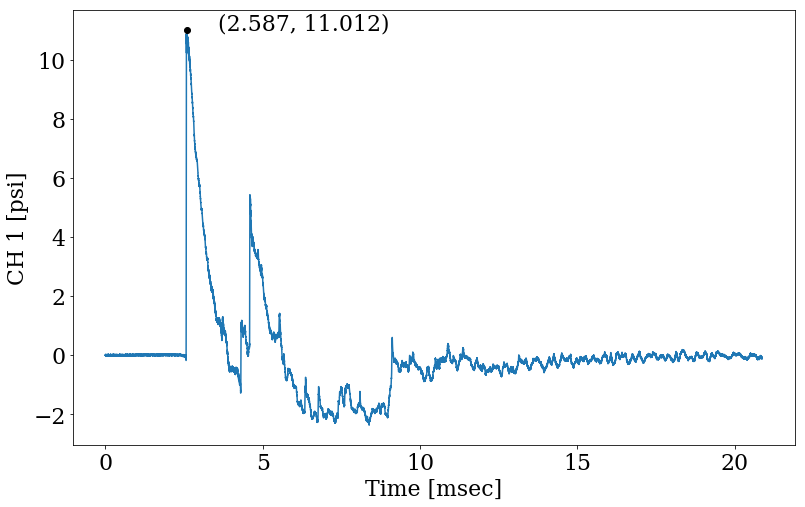

In [61]:
shot_data_dc[0:25].plot(figsize=(w,h));
plt.plot(peak_t, peak_p, 'ko');
plt.text(peak_t+1, peak_p, '({}, {})'.format(f_peak_t, f_peak_p));
plt.ylabel(cH);

Now that we have the peak value we need to find the start of the rise in pressure.  I'm going to define this as the first positive pressure point that occurs if you move from the peak pressure backward in time.  We can find this point by first deleting the data to the right of the peak.

In [62]:
left_peak = shot_data_dc[:peak_t] # new dataframe called left_peak that includes all the data in channel 1 up to the peak pressure.
left_peak.head() # first five rows of the new dataframe left_peak.

Time [msec]
-0.3350   -0.023798
-0.3345   -0.019036
-0.3340   -0.020623
-0.3335   -0.031733
-0.3330   -0.028559
Name: CH 1 [psi], dtype: float64

Next we need to reverse sort the data so that we start with the peak pressure.

In [63]:
left_peak_rev = left_peak.iloc[::-1]
left_peak_rev.head()

Time [msec]
2.5865    11.011622
2.5860    10.913222
2.5855    10.818022
2.5850    10.733822
2.5845    10.649722
Name: CH 1 [psi], dtype: float64

As you can see we're at the peak pressure now, 11.012 psi, and the time is going backwards.  Now we need to find the pressure in channel 1 where it first goes negative.  Then we will move one time step forward and that is where we say the positive pressure phase starts.  To do that we need to first find where the pressure goes negative and record the time where that occurs.

In [64]:
neg_idx_t = left_peak_rev.index[left_peak_rev < 0][0]
f_neg_idx_t = format(neg_idx_t, '0.3f')
f_neg_idx_t

'2.565'

Now we have the time, 2.565 ms, when the pressure first goes negative as we move left of the peak pressure.  Now we need to take that time index and convert it to an integer index.  Using our original shot_data dataframe we can pull out the integer index.

In [65]:
neg_idx_int = shot_data_dc.index.get_loc(neg_idx_t)
neg_idx_int

5800

Now that we have the integer index, 5800, for the first negative pressure value we can shift one time increment in the positive direction and capture the beginning pressure of the positive phase.

In [66]:
pos_phase_p_str = shot_data_dc.iloc[neg_idx_int+1]
pos_phase_t_str = shot_data_dc.index.values[neg_idx_int+1]
f_pos_phase_t_str = format(pos_phase_t_str, '0.3f')
f_pos_phase_p_str = format(pos_phase_p_str, '0.3f')
TOA = pos_phase_t_str
f_pos_phase_t_str, f_pos_phase_p_str

('2.566', '0.033')

So the beginning of the positive phase starts at 2.566 ms at a pressure of 0.033 psi.

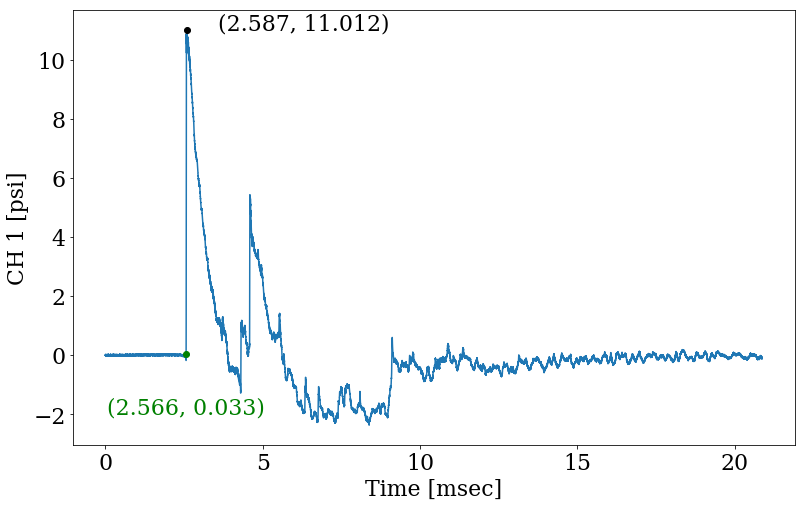

In [67]:
shot_data_dc[0:25].plot(figsize=(w,h));
plt.plot(peak_t, peak_p, 'ko');
plt.plot(pos_phase_t_str, pos_phase_p_str, 'go');
plt.text(pos_phase_t_str-2.5, pos_phase_p_str-2, '({}, {})'.format(f_pos_phase_t_str,
                                                                   f_pos_phase_p_str),
                                                                   color='g');
plt.text(peak_t+1, peak_p, '({}, {})'.format(f_peak_t, f_peak_p), color='k');
plt.ylabel(cH);

So now we have the both the pressure 0.033 psi and time 2.566 ms where the pressure goes positive right before the abrupt shoot up to peak pressure.  It would be intresting to find the number points between the start of the positive phase and the peak pressure.  We can do that with the following code,

In [68]:
num_points_rise = len(shot_data_dc[pos_phase_t_str : peak_t])
RT = num_points_rise*difference
RT, num_points_rise

(0.02150000000000002, 43)

So there is $0.0215\:ms$ (43 data points) between the start of the positive phase and the peak pressure.  To have $95\%$ confidence we captured the peak pressure we would want $10$ points.  For a $99\%$ confidence we captured the peak pressure we would want $27$ points.  So the sample rates for this test were very good at 43 data points.[5]

Now we need to find the end of the positive phase.  This will be done similarly to how we found the start of the positive phase except we will not need to reverse the sort of the time index.  So to start we will delete all the data to the left of the peak pressure.

In [69]:
right_peak = shot_data_dc[peak_t:]
right_peak.head()

Time [msec]
2.5865    11.011622
2.5870    10.917922
2.5875    10.865622
2.5880    10.910022
2.5885    10.846522
Name: CH 1 [psi], dtype: float64

Now we have the the pressure-time data starting at the peak pressure.  So now we can ask the question at what time does the pressure go negative.

In [70]:
neg_idx_t_end = right_peak.index[right_peak < 0][0]
f_neg_idx_t_end = format(neg_idx_t_end, '0.3f')
f_neg_idx_t_end

'3.886'

Starting at the peak pressure and moving to the right in the data the pressure goes negative at a time of 3.886 ms which, looks about right from the plot.  Now as before we need to find the integer index for this point.

In [71]:
neg_idx_int_end = shot_data_dc.index.get_loc(neg_idx_t_end)
neg_idx_int_end

8442

Now that we have the integer index, 8442, for the first negative pressure value at the end of the positive pressure phase we can shift one time increment back in time and capture the ending pressure of the positive phase.

In [72]:
pos_phase_p_end = shot_data_dc.iloc[neg_idx_int_end-1]
pos_phase_t_end = shot_data_dc.index.values[neg_idx_int_end-1]
f_pos_phase_t_end = format(pos_phase_t_end, '0.3f')
f_pos_phase_p_end = format(pos_phase_p_end, '0.3f')
f_pos_phase_t_end, f_pos_phase_p_end

('3.885', '0.027')

The end of the positive phase occurs at 3.885 ms at a pressure of 0.027 psi.

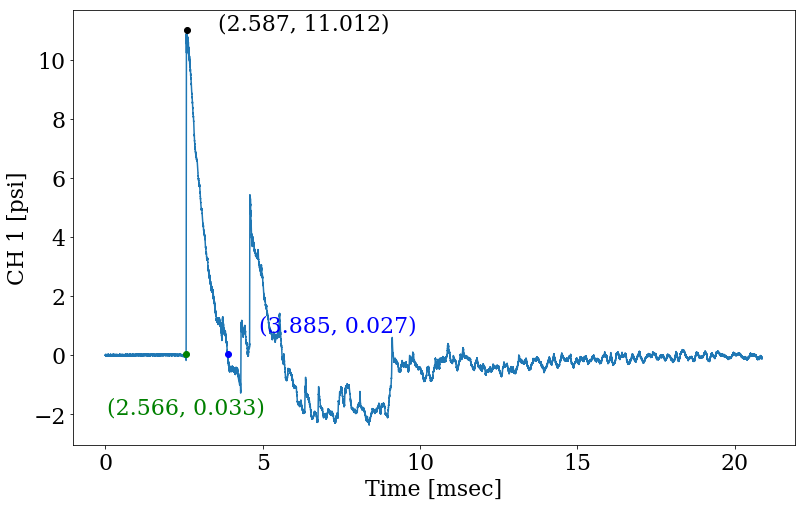

In [73]:
shot_data_dc[0:25].plot(figsize=(w,h));
plt.plot(peak_t, peak_p, 'ko');
plt.plot(pos_phase_t_str, pos_phase_p_str, 'go');
plt.plot(pos_phase_t_end, pos_phase_p_end, 'bo');
plt.text(pos_phase_t_str-2.5, pos_phase_p_str-2, '({}, {})'.format(f_pos_phase_t_str, f_pos_phase_p_str), color='g');
plt.text(pos_phase_t_end+1, pos_phase_p_end+0.75, '({}, {})'.format(f_pos_phase_t_end, f_pos_phase_p_end), color='b');
plt.text(peak_t+1, peak_p, '({}, {})'.format(f_peak_t, f_peak_p), color='k');
plt.ylabel(cH);

Now that we have both the start and end of the positive phase duration we can calculate the duration of the positive phase.

In [74]:
pos_phase_dur = pos_phase_t_end - pos_phase_t_str
f_pos_phase_dur = format(pos_phase_dur, '0.3f')
f_pos_phase_dur

'1.320'

So the total positive phase duration is 1.320 ms.  Plotting the positive phase looks like the following:

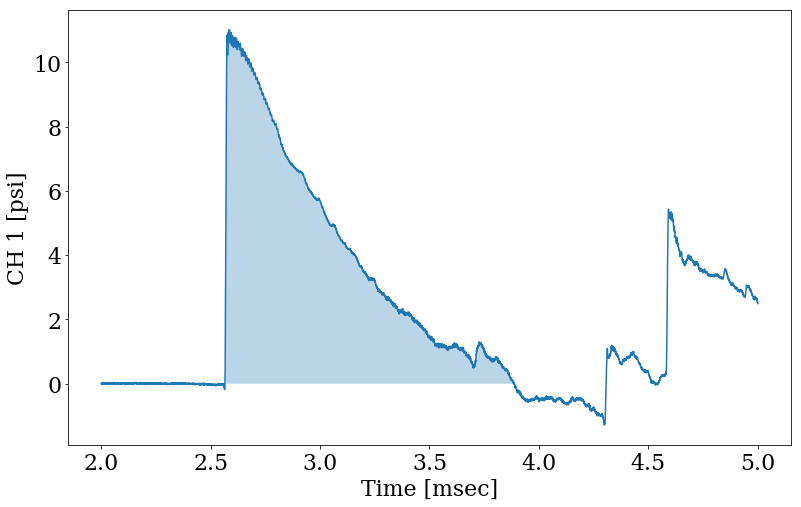

In [75]:
shot_data_dc[2:5].plot(figsize=(w,h))
plt.ylabel(cH)
plt.fill_between(shot_data.index, 0, shot_data[cH],
                 where=(shot_data.index >= pos_phase_t_str) & (shot_data.index <= pos_phase_t_end),
                 alpha=0.3)

Now that we have the beginning and ending times of the positive phase we can calculate the impulse using simpson's rule.

In [76]:
def impulse(dframe, t_start, t_end):
    from scipy import integrate # loads integrate functions
    p = dframe[t_start:t_end].values.transpose() #slice y values from dataframe
    t = dframe[t_start:t_end].index.values #slice x values from dataframe
    i = integrate.simps(p,t) #integrate y values from start time to end time
    return i #returns non-array value of impulse

In [77]:
dataImpulse = impulse(shot_data_dc,pos_phase_t_str,pos_phase_t_end)
f_dataImpulse = format(dataImpulse, '0.3f')
f_dataImpulse

'5.543'

The impulse is 5.543 psi-ms.

The next step is to apply the Friedlander equation from the peak to the end of the positive phase.  This will allow for an improved estimation of the peak pressure as, according to the manufacturer (PCB) pressure transducers the transducers can overshoot due high frequency noise in the blast wave and excite the structural resonance of the housed quartz transduction element.  At peak overpressures above about one atmosphere,  the Friedlander equation is no longer able to describe accurately the pressure time-histories, and it is necessary to introduce another coefficient, α, in a modified version of the equation. [1][2][3]

So, the modified Frielander equation is,

$$p(t)=P_s e^{-\alpha t} \left(1-\frac{t}{t^+} \right)$$

where $p$ is the overpressure at a fixed location, $P_s$ is the peak overpressure immediately behind the primary shock, $\alpha$ is a new parameter used for shocks over $1\:atm$ and, $t^+$ is the positive duration.

We can esimate the values for $P_s$, $\alpha$, and $t^+$ using a non-linear curve fit.

[[Model]]
    Model(friedlander)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 2599
    # variables        = 3
    chi-square         = 85.1394879
    reduced chi-square = 0.03279641
    Akaike info crit   = -8878.91824
    Bayesian info crit = -8861.32960
[[Variables]]
    p_s:     11.4467781 +/- 0.01289489 (0.11%) (init = 11.01162)
    alpha:   0.97376494 +/- 0.00660660 (0.68%) (init = 0.35)
    t_plus:  1.41732445 +/- 0.00491024 (0.35%) (init = 1.32)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, t_plus) =  0.872
    C(p_s, alpha)    =  0.687
    C(p_s, t_plus)   =  0.404

           99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 p_s   :  -0.03811  -0.02532  -0.01272  11.44678  +0.01274  +0.02536  +0.03811
 alpha :  -0.01908  -0.01275  -0.00640   0.97376  +0.00644  +0.01292  +0.01945
 t_plus:  -0.01401  -0.00943  -0.00476   1.41732  +0.00487  +0.00980  +0.01486


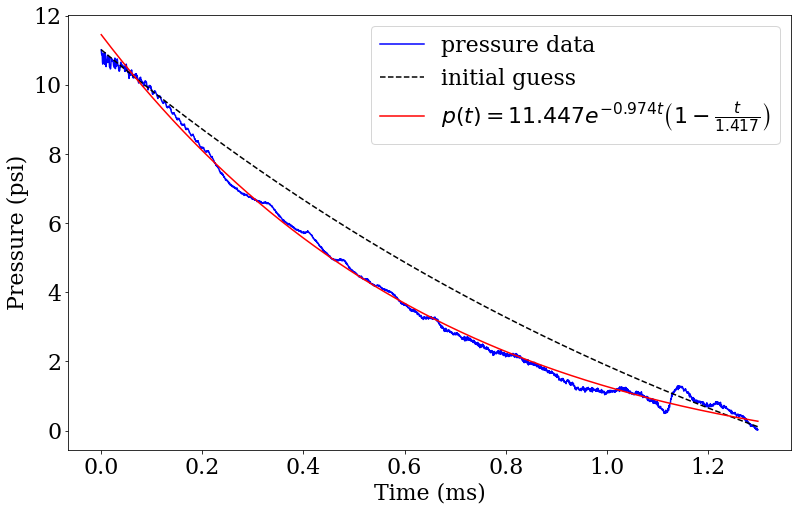

In [85]:
from numpy import exp
from lmfit import minimize, Parameters, Model

# reset time to zero ms by subtracting t at start of array
t = shot_data_dc[peak_t:pos_phase_t_end].index.values - shot_data_dc[peak_t:pos_phase_t_end].index.values[0] 
p = shot_data_dc[peak_t:pos_phase_t_end].values

def friedlander(t, p_s, alpha, t_plus):
    return ((1-(t/t_plus))*p_s*exp(-alpha*t))

fmodel = Model(friedlander)

result = fmodel.fit(p, t = t,
                    method='leastsq',
                    p_s = peak_p,
                    alpha = 0.35,
                    t_plus = pos_phase_dur)

delp =       result.eval_uncertainty(t=t, sigma=3.0) # calculates the sigma 3 (99) at each point.
ci_values =  result.conf_interval() # table of ci values
best_value = result.best_values # all of the best fit values
p_CI_99_plus =  list(result.ci_out.items())[0][1][6][1] #covnert ci_out to list then pick 99+
p_CI_99_minus = list(result.ci_out.items())[0][1][0][1] #covnert ci_out to list then pick 99-
p_CI_99_best =  list(result.ci_out.items())[0][1][3][1] #convert ci_out to list then pick 0
n_pts = result.ndata

f_ps = format(best_value["p_s"], '0.3f')
f_a = format(best_value["alpha"], '0.3f')
f_tp = format(best_value["t_plus"], '0.3f')
f_p_CI_99_minus = format(p_CI_99_minus, '0.3f')
f_p_CI_99_plus = format(p_CI_99_plus, '0.3f')
f_n_pts = format(n_pts, '0,.0f')

print(result.fit_report())
print(result.ci_report())

fig, ax = plt.subplots(figsize=(w,h))
plt.plot(t, p,'b', label='pressure data')
plt.plot(t, result.init_fit, 'k--', label = 'initial guess')
fit = plt.plot(t, result.best_fit, 'r-', label= r'$p(t)={} e^{{-{}t}} \left(1-\frac{{t}}{{{}}} \right)$'.format(f_ps,f_a,f_tp))
plt.xlabel('Time (ms)')
plt.ylabel('Pressure (psi)')
plt.legend()

In [79]:
f_n_pts, f_p_CI_99_minus, f_p_CI_99_plus

('2,599', '11.409', '11.485')

The non-linear least-square curve fit of the pressure over the time from peak pressure to the end of the positive phase was, n = 2599, 99% CI [11.409, 11.485] (psi).

In [80]:
#summary peak pressure, impulse, positive phase duration
dataSummaryTable = pd.DataFrame({'Peak P Data (psi)' : peak_p,
                                 'Positive Phase Data (ms)' : pos_phase_dur,
                                 'Impulse Data (psi-ms)' : dataImpulse,
                                 'SD (ft/lb^1/3)' : sd,
                                 'Weight (lb)' : weight_lb,
                                 'Distance (ft)' : dist_ft,
                                 'Distance (m)' : dist_m,
                                 'TOA (ms)' : TOA,
                                 'RT (ms)' : RT,
                                 'Sensor' : sensor,
                                 'Clean Signal' : 'yes'},
                                 index=[cH[0:len(cH)-6]])
dataSummaryTable

,Peak P Data (psi),Positive Phase Data (ms),Impulse Data (psi-ms),SD (ft/lb^1/3),Weight (lb),Distance (ft),Distance (m),TOA (ms),RT (ms),Sensor,Clean Signal
CH 1,11.011622,1.32,5.543122,7.899132,0.573201,6.56168,2,2.5655,0.0215,Incident,yes


[1] L. Walter, Patrick, “Measuring Static Overpressures in Air Blast Environments, TN-27,” Depew, NY, 2010.

[2] J. M. Dewey, “Measurement of the Physical Properties of Blast Waves,” in Experimental Methods of Shock Wave Research, Cham: Springer International Publishing, 2016, pp. 53–86.

[3] G. F. Kinney, K. J. Graham, G. F. Kinney, and K. J. Graham, Explosive shocks in air, 2nd ed. New York: Springer-Verlag New York Inc., 1985.

[4] Newville, M., Stensitzki, T., Allen, D. B., & Ingargiola, A. (2014, September 21). LMFIT: Non-Linear Least-Square Minimization and Curve-Fitting for Python. Zenodo. http://doi.org/10.5281/zenodo.11813



